<a href="https://colab.research.google.com/github/Sibusisongwenya/WIP-Project/blob/main/Team_5_WIP_Code_for_MCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
device:  cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may 

Calibration Epoch 1/100, Temperature: 37.7241
Calibration Epoch 2/100, Temperature: 374.6076
Calibration Epoch 3/100, Temperature: 406.6168
Calibration Epoch 4/100, Temperature: 452.2399
Calibration Epoch 5/100, Temperature: 491.0539
Calibration Epoch 6/100, Temperature: 546.3784
Calibration Epoch 7/100, Temperature: 554.3998
Calibration Epoch 8/100, Temperature: 557.1002
Calibration Epoch 9/100, Temperature: 570.8041
Calibration Epoch 10/100, Temperature: 593.4479
Calibration Epoch 11/100, Temperature: 608.0620
Calibration Epoch 12/100, Temperature: 614.0095
Calibration Epoch 13/100, Temperature: 638.3973
Calibration Epoch 14/100, Temperature: 650.9578
Calibration Epoch 15/100, Temperature: 670.2708
Calibration Epoch 16/100, Temperature: 683.4684
Calibration Epoch 17/100, Temperature: 731.7717
Calibration Epoch 18/100, Temperature: 742.5649
Calibration Epoch 19/100, Temperature: 760.9136
Calibration Epoch 20/100, Temperature: 764.6382
Calibration Epoch 21/100, Temperature: 783.5395
Ca

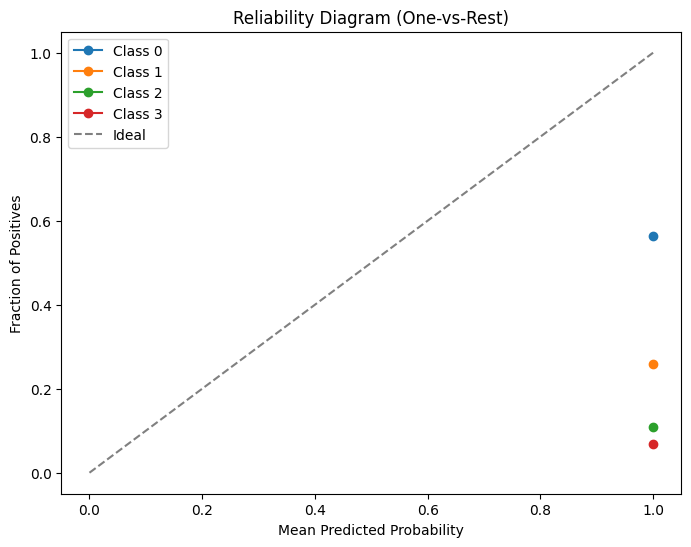

Average Expected Calibration Error (ECE) for Classification: 0.7500


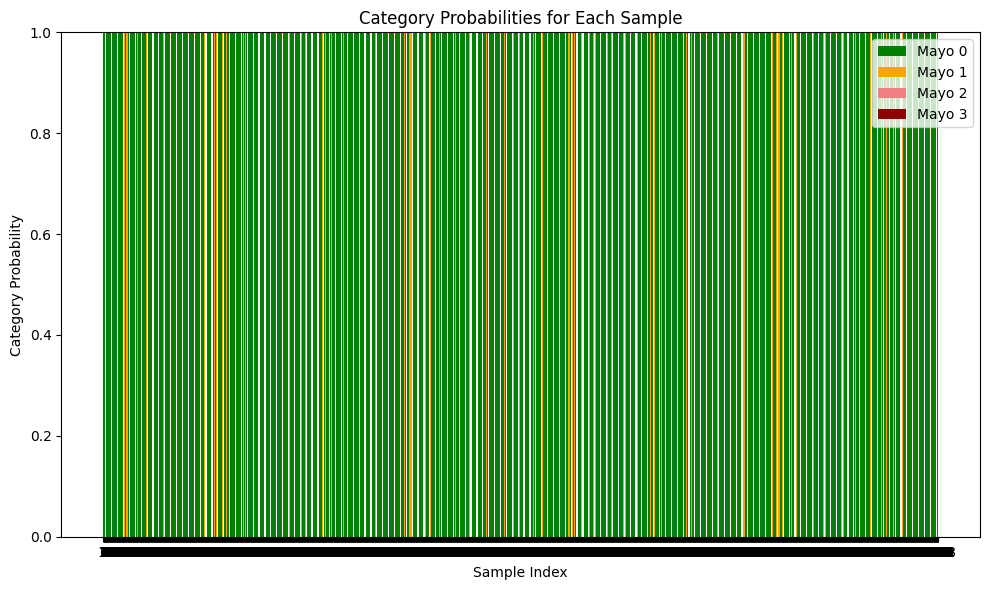

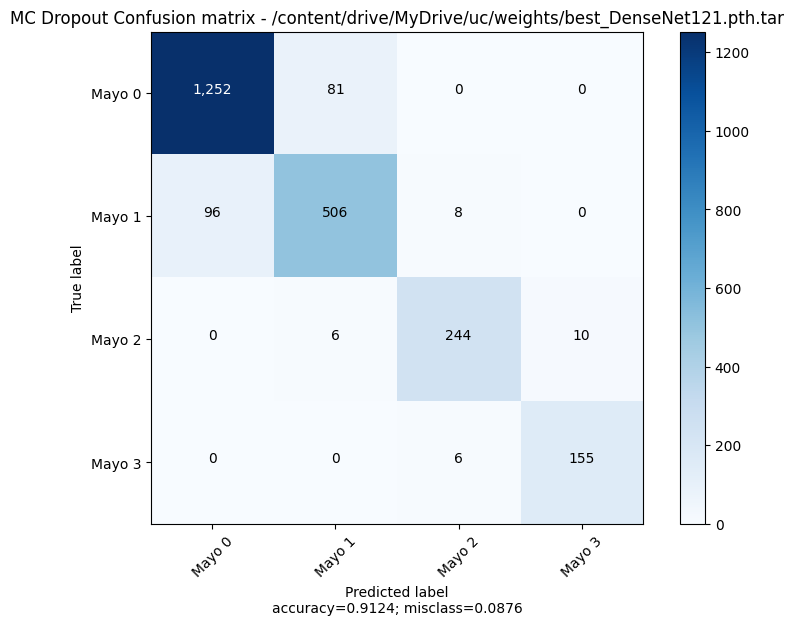

------------ MC Dropout Classification Report (All) ------------

Average Accuracy (MC Dropout): 0.9124
QWK score (MC Dropout): 0.9485090448096779
Average Sensitivity (MC Dropout): 0.9175
Average Specificity (MC Dropout): 0.9615

------------ Confidence Metrics ------------

Average Regression Confidence: 1.0000
Average Regression Standard Deviation: 0.0000
Average Classification Confidence: 1.0000


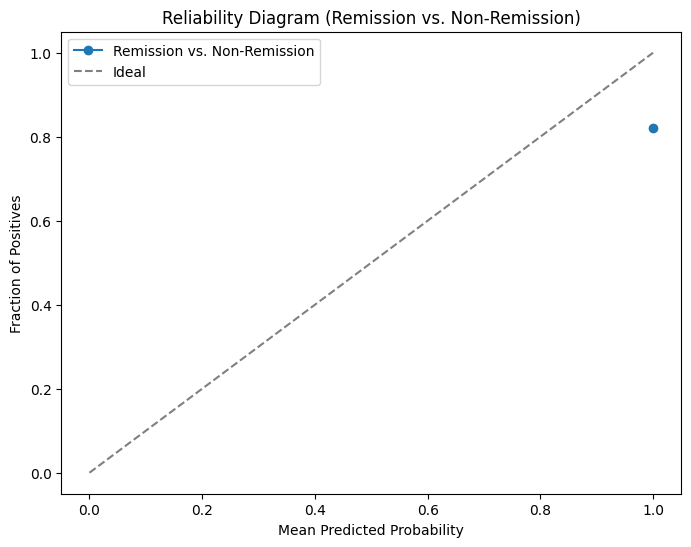

Expected Calibration Error (ECE) for Remission vs. Non-Remission: 0.1781


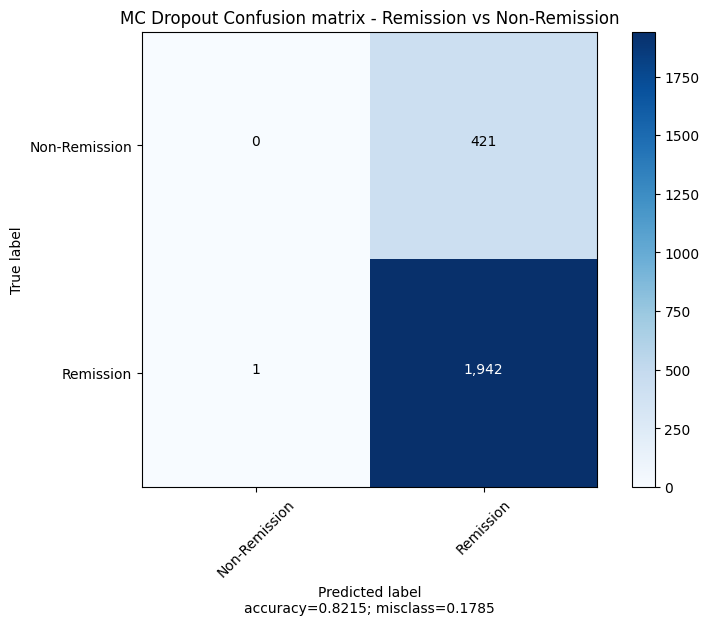

------------ MC Dropout Classification Report (Remission vs Non-Remission) ------------

Average Accuracy (MC Dropout): 0.8215
QWK score (MC Dropout): -0.0008447318628443945
Average Sensitivity (MC Dropout): 0.4997
Average Specificity (MC Dropout): 0.4997

------------ Confidence Metrics ------------

Average Regression Confidence: 1.0000
Average Regression Standard Deviation: 0.0000
Average Classification Confidence: 1.0000
MCD Analysis Results:
mean_prediction_mcd: -0.0142
std_prediction_mcd: 0.0000
mean_ci_width_mcd: 0.0000


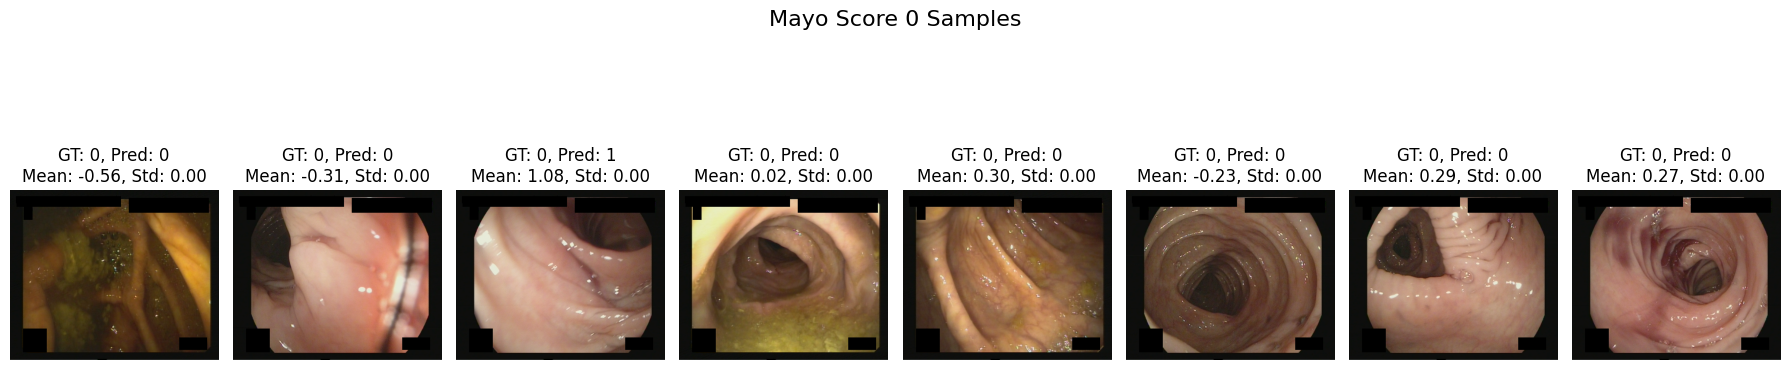

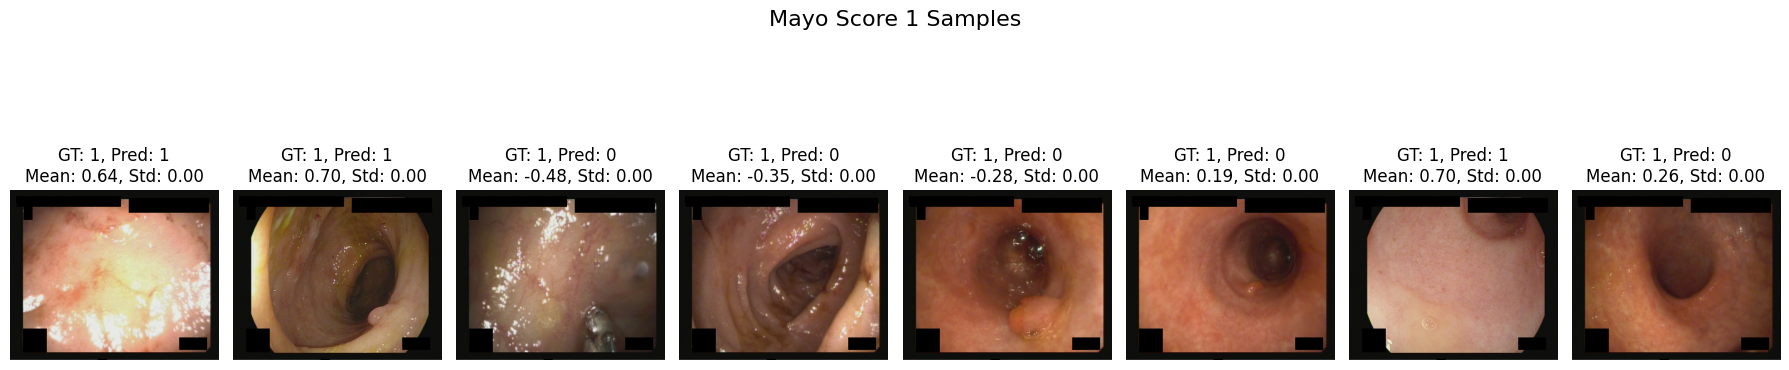

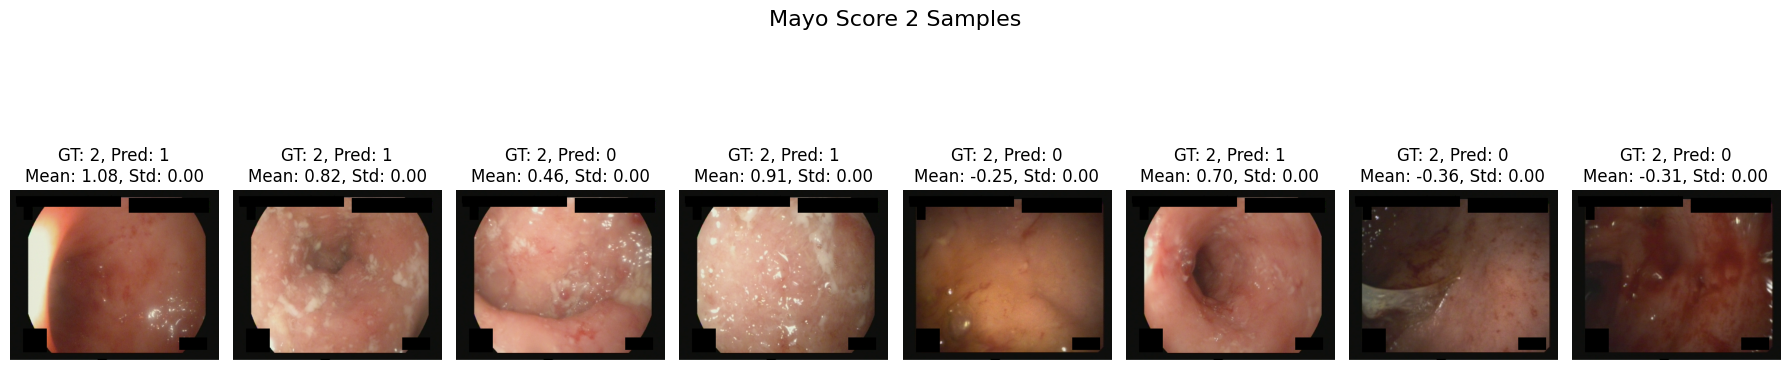

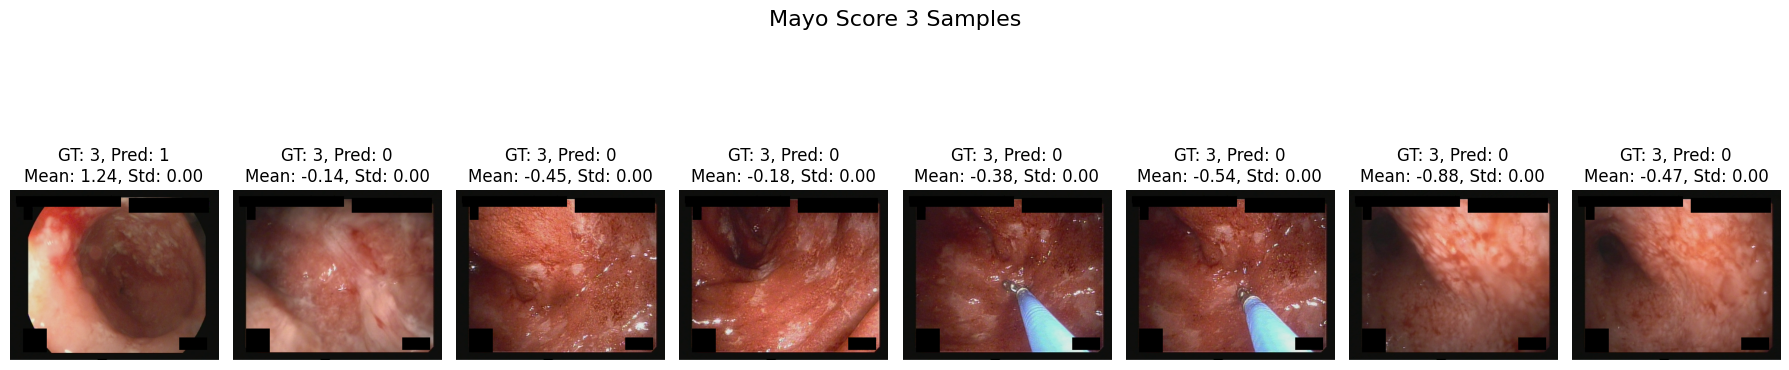

In [2]:
# Caveat code is functional provide at this point for purpose of aiding understanding of team 5's research work currently in progress
# keep in mind teh model and therefore code is constantly updated this file will be updated every 2 to 3 days


import os
import sys
# Append the project root to the Python path
sys.path.append('/content/drive/MyDrive/uc')

import numpy as np
import torch
from torch.optim import LBFGS
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, precision_recall_fscore_support,cohen_kappa_score, accuracy_score,confusion_matrix
import argparse
import matplotlib.pyplot as plt
from IPython import get_ipython
from statistics import stdev
from sklearn.calibration import calibration_curve
from dataset.ucmayo4 import UCMayo4
from utils.metrics import get_mean_sensitivity_specificity
from utils import provider
from utils.provider import get_test_results_regression, get_regression_accuracy_with_boundaries, \
    setup_reproducability, get_dataset_mean_and_std,initialize_model, write_metric_results_to_file, get_batch_size_for_model
import scipy
import scipy.stats

parser = argparse.ArgumentParser(description="Arguments for the inference with Monte Carlo Dropout.")

parser.add_argument("--train_dir", type=str, default="/content/drive/MyDrive/uc/test_set/train", help="path to training set.")
parser.add_argument("--test_dir", type=str, default= "/content/drive/MyDrive/uc/test_set/test", help="path to validation set.")
parser.add_argument("--model_name", type=str,  default="DenseNet121",
                    choices=["ResNet18", "ResNet50", "VGG16_bn", "DenseNet121", "Inception_v3", "MobileNet_v3_large"],
                    help="Name of the CNN architecture.")
parser.add_argument("--checkpoint", type=str, default="/content/drive/MyDrive/uc/weights/best_DenseNet121.pth.tar", help="path to checkpoint file.")
parser.add_argument("--dropout_rate", type=float, default=0.5, help="Dropout rate to be used during inference.")
parser.add_argument("--num_monte_carlo_samples", type=int, default=50, help="Number of Monte Carlo samples.")

args = parser.parse_args([])

num_worker = 8
state_dict_name = args.checkpoint
model_name = args.model_name
dropout_rate = args.dropout_rate
num_monte_carlo_samples = args.num_monte_carlo_samples

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

train_dir = args.train_dir
test_dir = args.test_dir

channel_means, channel_stds = get_dataset_mean_and_std(train_dir)
normalize = transforms.Normalize(mean=channel_means,
                                     std=channel_stds)

def add_dropout(model, dropout_prob=0.2):
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):  # Add dropout after ReLU (common practice)
            new_dropout = nn.Dropout(p=dropout_prob)
            # Create a Sequential containing ReLU and Dropout
            seq = nn.Sequential(module, new_dropout)
            # Replace the original ReLU with the Sequential
            # Note: This replacement needs to be done carefully, as directly replacing
            # a module in-place can have unintended effects. A better way would be to
            # create a new model and copy the weights, but for simplicity, we'll
            # use this approach here.
            split_name = name.rsplit('.', 1)
            if isinstance(split_name,list) and len(split_name) == 1: # Handle the case where rsplit returns a list
                parent_name = "" # handle the top level case
            else:
                parent_name = split_name[0] # take the parent name
            parent = dict(model.named_modules())[parent_name]
            setattr(parent, name.rsplit('.', 1)[-1], seq)
    return model

# DenseNet121:
densenet = models.densenet121(pretrained=True)  # Or pretrained=False
densenet = add_dropout(densenet) # Add dropout to the model
densenet.classifier = nn.Sequential(nn.Linear(densenet.classifier.in_features, 1)) # Modify the classifier for regression

# ResNet50:
resnet = models.resnet50(pretrained=True)  # Or pretrained=False
resnet = add_dropout(resnet) # Add dropout to the model
resnet.fc = nn.Sequential(nn.Linear(resnet.fc.in_features, 1)) # Modify the fully connected layer for regression


# Initialize model and load checkpoint, configure dropout
model = initialize_model(model_name, False, 1) # num_classes=1 for regression
model.load_state_dict(torch.load(state_dict_name))

# Enable dropout in the model (if not already active in eval mode for some layers)
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train() # Important to set dropout to training mode during inference for MCD

enable_dropout(model)
model.to(device)
model.eval() # Set to eval mode, but dropout is explicitly enabled for MCD

def get_monte_carlo_predictions_regression(model, data_loader, device, num_samples):
    model.eval() # Ensure eval mode, but dropout is enabled by enable_dropout
    predictions = []
    true_labels = []
    with torch.no_grad(): # No gradient calculation for inference
        for data, target in data_loader:
            data = data.to(device)
            sample_predictions = []
            for _ in range(num_samples): # Monte Carlo loop
                output = model(data) # Forward pass with dropout active
                output = output.cpu().numpy().flatten() # Get prediction as numpy array
                sample_predictions.append(output)
            predictions.extend(np.array(sample_predictions).T.tolist()) # Store flattened predictions for each sample, not yet flattened

            true_labels.extend(target.cpu().numpy()) # extend true_labels by all values in the target tensor

    # Flatten the predictions, now that confidence scores have been calculated
    #predictions = [preds.flatten() for preds in predictions] #Remove this line as we are flattening above
    return predictions, true_labels, None # confidence scores are not calculated here


def calculate_regression_confidence(mc_predictions, method="inverse_std"):
    confidence_scores = []
    std_devs = []
    for sample_preds in mc_predictions:
        std = stdev(sample_preds)
        std_devs.append(std)
        if method == "inverse_std":
            confidence = 1.0 / (1.0 + std)  # Inverse of standard deviation
        elif method == "negative_std":
            confidence = -std  # Negative of standard deviation
        elif method == "exp_neg_std":
            confidence = np.exp(-std)  # Exponential of negative standard deviation
        else:
            raise ValueError("Invalid confidence method specified.")
        confidence_scores.append(confidence)
    return confidence_scores, std_devs
    return classification_confidences, predicted_classes_mc
# %%
def calculate_classification_confidence(mc_predictions, boundaries, method="entropy"):
    classification_confidences = []
    predicted_classes_mc =[]
    for sample_preds in mc_predictions:
        class_predictions = []
        for pred in sample_preds:
            predicted_class_tensor = get_regression_accuracy_with_boundaries(torch.tensor([pred]), torch.tensor(0), boundaries) # Dummy target
            predicted_class = predicted_class_tensor.item()
            class_predictions.append(predicted_class)
        predicted_classes_mc.append(class_predictions)

        if method == "entropy":
            class_probs = np.bincount(np.array(class_predictions, dtype=np.int64), minlength=4) / len(class_predictions)
            entropy = -np.sum([p * np.log(p) if p > 0 else 0 for p in class_probs])  # Calculate entropy
            confidence = np.exp(-entropy)  # Use exp(-entropy) as confidence (higher entropy = lower confidence) and transform to probability like range
        elif method == "max_prob":
            class_counts = np.bincount(np.array(class_predictions, dtype=np.int64), minlength=4)
            most_frequent_class = np.argmax(class_counts)
            confidence = class_counts[most_frequent_class] / len(class_predictions)  # Frequency of most frequent class
        else:
            raise ValueError("Invalid confidence method specified.")
        classification_confidences.append(confidence)
    return classification_confidences, predicted_classes_mc



# Load test dataset and create test_loader
test_dataset = UCMayo4(test_dir, transform=transforms.Compose([transforms.ToTensor(), normalize]))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Perform Monte Carlo Dropout Inference
mc_regression_predictions, y_true_regression, _ = get_monte_carlo_predictions_regression(model, test_loader, device, num_monte_carlo_samples)

# Calculate Confidence Metrics for Regression (using different methods)
regression_confidence_scores_inv_std, regression_std_devs = calculate_regression_confidence(mc_regression_predictions, method="inverse_std")
regression_confidence_scores_neg_std, _ = calculate_regression_confidence(mc_regression_predictions, method="negative_std")
regression_confidence_scores_exp_neg_std, _ = calculate_regression_confidence(mc_regression_predictions, method="exp_neg_std")


# Calculate Confidence Metrics for Classification (derived from regression)
boundaries = [0.5, 1.5, 2.5]
classification_confidence_scores, predicted_classes_mc = calculate_classification_confidence(mc_regression_predictions, boundaries)

# Get final class predictions by averaging or mode from MC samples (using mode - most frequent class)
y_pred_classes = []
for sample_classes in predicted_classes_mc:
    class_counts = np.bincount(np.array(sample_classes, dtype=np.int64), minlength=4)
    most_frequent_class = np.argmax(class_counts)
    y_pred_classes.append(most_frequent_class)


# %%
def temperature_scaling(logits, temperature):
    return logits / temperature

def calibrate_model(model, val_loader, device, num_monte_carlo_samples, num_epochs=100, learning_rate=0.01):
    temperature = torch.nn.Parameter(torch.ones(1).to(device))  # Initialize temperature
    optimizer = LBFGS([temperature], lr=learning_rate, max_iter=1000)  # Use L-BFGS optimizer

    # Enable dropout for MCD
    enable_dropout(model)
    model.eval()

    for epoch in range(num_epochs):
        def closure():
            optimizer.zero_grad()
            loss = 0.0
            for data, target in val_loader:
                data, target = data.to(device), target.to(device).float()
                mc_predictions = []
                for _ in range(num_monte_carlo_samples):
                    output = model(data)
                    mc_predictions.append(output)
                mc_predictions = torch.stack(mc_predictions)
                mean_prediction = torch.mean(mc_predictions, dim=0)
                scaled_prediction = temperature_scaling(mean_prediction, temperature)
                target = target.unsqueeze(1) # add an extra dimension to the target tensor
                loss += F.mse_loss(scaled_prediction, target)  # Use MSE loss for calibration
            loss.backward()
            return loss

        optimizer.step(closure)
        print(f"Calibration Epoch {epoch + 1}/{num_epochs}, Temperature: {temperature.item():.4f}")

    return temperature

# Load your validation set into a DataLoader - val_loader
# Assuming val_dir is defined similarly to train_dir and test_dir, replace with correct path
val_dir = "/content/drive/MyDrive/uc/test_set/test"
channel_means, channel_stds = get_dataset_mean_and_std(val_dir)
normalize = transforms.Normalize(mean=channel_means,
                                     std=channel_stds)
val_dataset = UCMayo4(val_dir, transform=transforms.Compose([transforms.ToTensor(), normalize]))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Dummy enable_dropout function, replace with your actual function if you have one.
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Get a sample batch from the dataloader to determine the input size
sample_batch = next(iter(val_loader))
sample_data = sample_batch[0]
# Calculate the size of the flattened input
flattened_size = np.prod(sample_data.shape[1:])


# Dummy model and device, replace with your actual model and device initialization
class DummyModel(torch.nn.Module):
    def __init__(self, flattened_size): # Input size from flattened tensor
        super().__init__()
        self.flatten = nn.Flatten() # Flatten layer to reshape the input into a vector
        self.fc = torch.nn.Linear(flattened_size, 1) # Linear layer with correct input size
    def forward(self, x):
        x = self.flatten(x) # Flatten the input tensor
        return self.fc(x)


model = DummyModel(flattened_size).to("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"

num_monte_carlo_samples = 10 # Replace with your actual number
# Calibrate the model
temperature = calibrate_model(model, val_loader, device, num_monte_carlo_samples)


# Perform MCD inference
mc_regression_predictions, y_true_regression, _ = get_monte_carlo_predictions_regression(model, test_loader, device, num_monte_carlo_samples)

# Apply temperature scaling to the mean predictions
mc_regression_predictions, y_true_regression, _ = get_monte_carlo_predictions_regression(model, test_loader, device, num_monte_carlo_samples)
mean_predictions = [np.mean(preds) for preds in mc_regression_predictions]
calibrated_predictions = temperature_scaling(torch.tensor(mean_predictions).to(device), temperature)

# Get the classification confidence scores and predicted classes
classification_confidence_scores, predicted_classes_mc = calculate_classification_confidence(mc_regression_predictions, boundaries, method="entropy")  # Or another method

# Get the true class labels (assuming y_true_regression contains the true Mayo scores)
y_true_classes = [get_regression_accuracy_with_boundaries(torch.tensor([score]), torch.tensor(0), boundaries).item() for score in y_true_regression]

# Calculate calibration curve and ECE for each class
num_classes = 4
eces = []
plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    # Create binary true labels for one-vs-rest
    y_true_binary = [1 if label == class_label else 0 for label in y_true_classes]

    # Bin the confidence scores and true labels
    prob_true, prob_pred = calibration_curve(y_true_binary, classification_confidence_scores, n_bins=10)

    # Plot the reliability diagram for each class
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_label}')

    # Calculate the Expected Calibration Error (ECE)
    ece = np.sum(np.abs(prob_true - prob_pred) * np.histogram(classification_confidence_scores, bins=10)[0] / len(classification_confidence_scores))
    eces.append(ece)

# Ideal calibration line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram (One-vs-Rest)')
plt.legend()
plt.show()


# Average ECE over all classes
mean_ece = np.mean(eces)
print(f"Average Expected Calibration Error (ECE) for Classification: {mean_ece:.4f}")

def visualize_category_probabilities(predicted_classes_mc, y_true_regression, boundaries, save_path=None):
    """
    Visualizes the category probabilities for each sample using stacked bar charts.

    Args:
      predicted_classes_mc: List of lists, where each inner list contains the predicted class for each MC sample.
      y_true_regression: List of true Mayo scores.
      boundaries: List of boundaries for Mayo score categories.
      save_path: Optional path to save the figure.
    """

    num_samples = len(predicted_classes_mc)
    category_names = ["Mayo 0", "Mayo 1", "Mayo 2", "Mayo 3"]
    colors = ['green', 'orange', 'lightcoral', 'darkred']  # Color coding for Mayo categories, replace 'amber' with 'orange'

    plt.figure(figsize=(10, 6))

    for i in range(num_samples):
        class_counts = np.bincount(np.array(predicted_classes_mc[i], dtype=np.int64), minlength=4)
        class_probabilities = class_counts / len(predicted_classes_mc[i])

        # Create stacked bar chart, plotting each segment individually
        bottom = 0
        for j in range(4):
            plt.bar(i, class_probabilities[j], bottom=bottom, color=colors[j], label=category_names[j] if i == 0 else "")
            bottom += class_probabilities[j]


    plt.xlabel("Sample Index")
    plt.ylabel("Category Probability")
    plt.title("Category Probabilities for Each Sample")
    plt.xticks(np.arange(num_samples))
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
visualize_category_probabilities(predicted_classes_mc, y_true_regression, boundaries, save_path="category_probabilities.png")

# Evaluate classification performance as before (using mode-predicted classes)
QWK_kappa_score = cohen_kappa_score(y_true_regression, y_pred_classes, weights="quadratic")
cm_all = confusion_matrix(y_true_regression, y_pred_classes)
provider.plot_confusion_matrix(cm_all, ["Mayo 0", "Mayo 1", "Mayo 2", "Mayo 3"],
                                            "MC Dropout Confusion matrix - " + state_dict_name, normalize=False)
accuracy = accuracy_score(y_true_regression, y_pred_classes)
mean_sensitivity, mean_specificity = get_mean_sensitivity_specificity(y_true_regression, y_pred_classes)


print("------------ MC Dropout Classification Report (All) ------------\n")
print("Average Accuracy (MC Dropout): {:0.4f}".format(accuracy))
print("QWK score (MC Dropout): " + str(QWK_kappa_score))
print("Average Sensitivity (MC Dropout): {:0.4f}".format(mean_sensitivity))
print("Average Specificity (MC Dropout): {:0.4f}".format(mean_specificity))
print("\n------------ Confidence Metrics ------------\n")
print("Average Regression Confidence: {:0.4f}".format(np.mean(regression_confidence_scores_inv_std))) # Use the confidence scores that were calculated correctly
print("Average Regression Standard Deviation: {:0.4f}".format(np.mean(np.std(mc_regression_predictions, axis=1))))
print("Average Classification Confidence: {:0.4f}".format(np.mean(classification_confidence_scores)))

# Get the classification confidence scores and predicted classes
classification_confidence_scores, predicted_classes_mc = calculate_classification_confidence(mc_regression_predictions, boundaries, method="entropy")

# Get the true class labels (assuming y_true_regression contains the true Mayo scores)
y_true_classes = [get_regression_accuracy_with_boundaries(torch.tensor([score]), torch.tensor(0), boundaries).item() for score in y_true_regression]

# Convert to binary remission (1) vs. non-remission (0) labels
y_true_binary = [1 if label <= 1 else 0 for label in y_true_classes]

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_true_binary, classification_confidence_scores, n_bins=10)

# Plot the reliability diagram
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Remission vs. Non-Remission')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram (Remission vs. Non-Remission)')
plt.legend()
plt.show()

# Calculate the Expected Calibration Error (ECE)
ece = np.sum(np.abs(prob_true - prob_pred) * np.histogram(classification_confidence_scores, bins=10)[0] / len(classification_confidence_scores))
print(f"Expected Calibration Error (ECE) for Remission vs. Non-Remission: {ece:.4f}")


# Evaluate classification performance as before (using mode-predicted classes)
# Convert predicted classes to binary remission (1) vs non-remission (0)
y_pred_classes = []
for sample_classes in predicted_classes_mc:
    class_counts = np.bincount(np.array(sample_classes, dtype=np.int64), minlength=4)
    most_frequent_class = np.argmax(class_counts)
    y_pred_classes.append(most_frequent_class)


y_pred_binary = [1 if label <= 1 else 0 for label in y_pred_classes]
QWK_kappa_score = cohen_kappa_score(y_true_binary, y_pred_binary, weights="quadratic")
cm_all = confusion_matrix(y_true_binary, y_pred_binary)
provider.plot_confusion_matrix(cm_all, ["Non-Remission", "Remission"],
                                            "MC Dropout Confusion matrix - Remission vs Non-Remission", normalize=False)
accuracy = accuracy_score(y_true_binary, y_pred_binary)
mean_sensitivity, mean_specificity = get_mean_sensitivity_specificity(y_true_binary, y_pred_binary)


print("------------ MC Dropout Classification Report (Remission vs Non-Remission) ------------\n")
print("Average Accuracy (MC Dropout): {:0.4f}".format(accuracy))
print("QWK score (MC Dropout): " + str(QWK_kappa_score))
print("Average Sensitivity (MC Dropout): {:0.4f}".format(mean_sensitivity))
print("Average Specificity (MC Dropout): {:0.4f}".format(mean_specificity))
print("\n------------ Confidence Metrics ------------\n")
print("Average Regression Confidence: {:0.4f}".format(np.mean(regression_confidence_scores_inv_std))) # Use the confidence scores that were calculated correctly
print("Average Regression Standard Deviation: {:0.4f}".format(np.mean(np.std(mc_regression_predictions, axis=1))))
print("Average Classification Confidence: {:0.4f}".format(np.mean(classification_confidence_scores)))
